In [103]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q

In [104]:
try:
    plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')
except:
    pass
device = "cpu"

In [105]:

outfile_name = f"thrust_2_3d"

save_dict = {}

with open(f"output/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)
   
losses = np.load(f"output/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = 2 #save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

print(save_dict["configs"])

{'distribution': 'thrust', 'run_toy': False, 'order_to_match': 2, 'name': '3d', 'mstar': 1, 'init_random': True, 'init_at_answer': False, 'init_close_to_answer': False, 'learn_theta': True, 'ratio_loss': False, 'weighted_mse_loss': False, 'use_logbins': False, 'n_bins': 100, 't_min': 0, 't_max': 10, 'epochs': 100, 'batch_size': 112, 'lr': 0.1, 'seed': 42, 'm': 3, 'n': 3, 'device': 'cuda'}


In [106]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = torch.tensor([math.factorial(k) for k in range(max_N)], device=device).float()
factorial_cache_m = torch.tensor([math.factorial(k) for k in range(max_M)], device=device).float()
n_range = torch.arange(max_N, device=device)
m_range = torch.arange(1, max_M, device=device)

factorial_cache_info = factorial_cache_m, factorial_cache_n, m_range, n_range



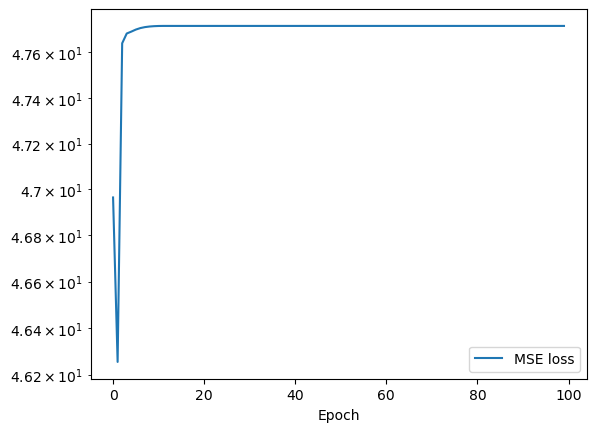

In [107]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



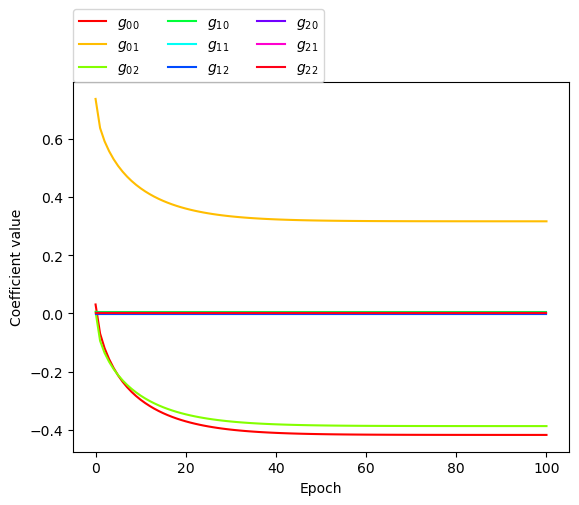

In [108]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



In [109]:



if save_dict["configs"]["use_logbins"]:
    t_bins = torch.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
    )
    t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])
   

if not run_toy:  # only needs to be done once
    data_dict,t_bins,t_bin_centers = read_in_data(distribution, order_to_match, device)
t_min = torch.min(t_bins)
t_max = torch.max(t_bins)
        



tt = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200, device=device)


colors = ["red", "purple", "blue"]


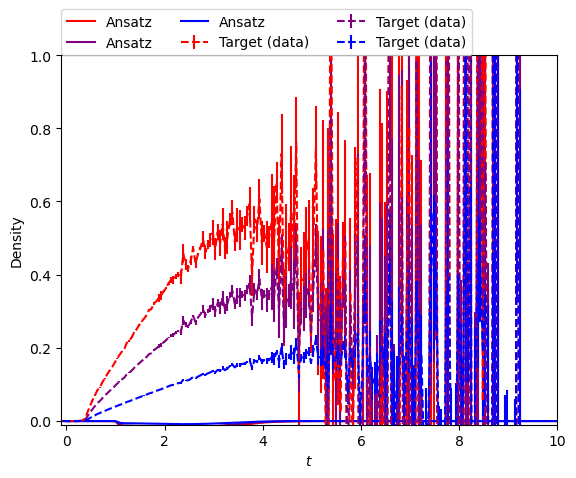

In [110]:

plt.figure()
for i, alpha in enumerate([0.148, 0.101, 0.049]):
    alpha_tensor = torch.tensor(alpha, device=device)

    # plot ansatz
    plt.plot(tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy(),label="Ansatz",color=colors[i],)

    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict[alpha]
        plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)

plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

## Plot Taylor expansion

In [ ]:

plt.figure(figsize=(12,8))


#g_coeffs_log[-1][:,2] = 0
#print(g_coeffs_log[-1])

for i, alpha in enumerate([0.148, 0.101, 0.049]):
    alpha_tensor = torch.tensor(alpha, device=device)

    # plot ansatz derivative
    alpha_zero = torch.tensor(0.0, device=device, requires_grad=True)
    fn = lambda a: q(
        t_bin_centers, a,  torch.tensor(g_coeffs_log[-1], device=device),  torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info
    )
    base = fn(alpha_zero)  # (args.n_bins-1,)

    if order_to_match >= 1:
            _, d1 = torch.autograd.functional.jvp(
                fn,
                (alpha_zero,),
                (torch.ones_like(alpha_zero),),
                create_graph=True,
            )  # (args.n_bins-1,)
    if order_to_match == 2:
        d1_fn = lambda a: torch.autograd.functional.jvp(
            fn, (a,), (torch.ones_like(a),), create_graph=True
        )[1]
        _, d2 = torch.autograd.functional.jvp(
            d1_fn,
            (alpha_zero,),
            (torch.ones_like(alpha_zero),),
            create_graph=True,
        )  # (args.n_bins-1,)




    batch_ansatz = base
    if order_to_match >= 1:
        batch_ansatz = batch_ansatz + alpha_tensor * d1
    if order_to_match == 2:
        batch_ansatz = batch_ansatz + 0.5 * (alpha_tensor ** 2) * d2

    plt.plot(t_bin_centers.detach().cpu().numpy(),batch_ansatz.detach().cpu().numpy(),label=f"Ansatz, order {order_to_match}",color=colors[i],)

    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict[alpha]
        plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)

plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

[[-0.41794714  0.31675714 -0.38757497]
 [-4.19184162 -7.82027799 -2.60684446]
 [ 6.75656482  1.73398003  1.95026766]]


NameError: name 'jnp' is not defined

<Figure size 1200x800 with 0 Axes>